In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
import mne
from nilearn import datasets
from nilearn import plotting
from nilearn import surface
from nilearn.datasets import fetch_surf_fsaverage

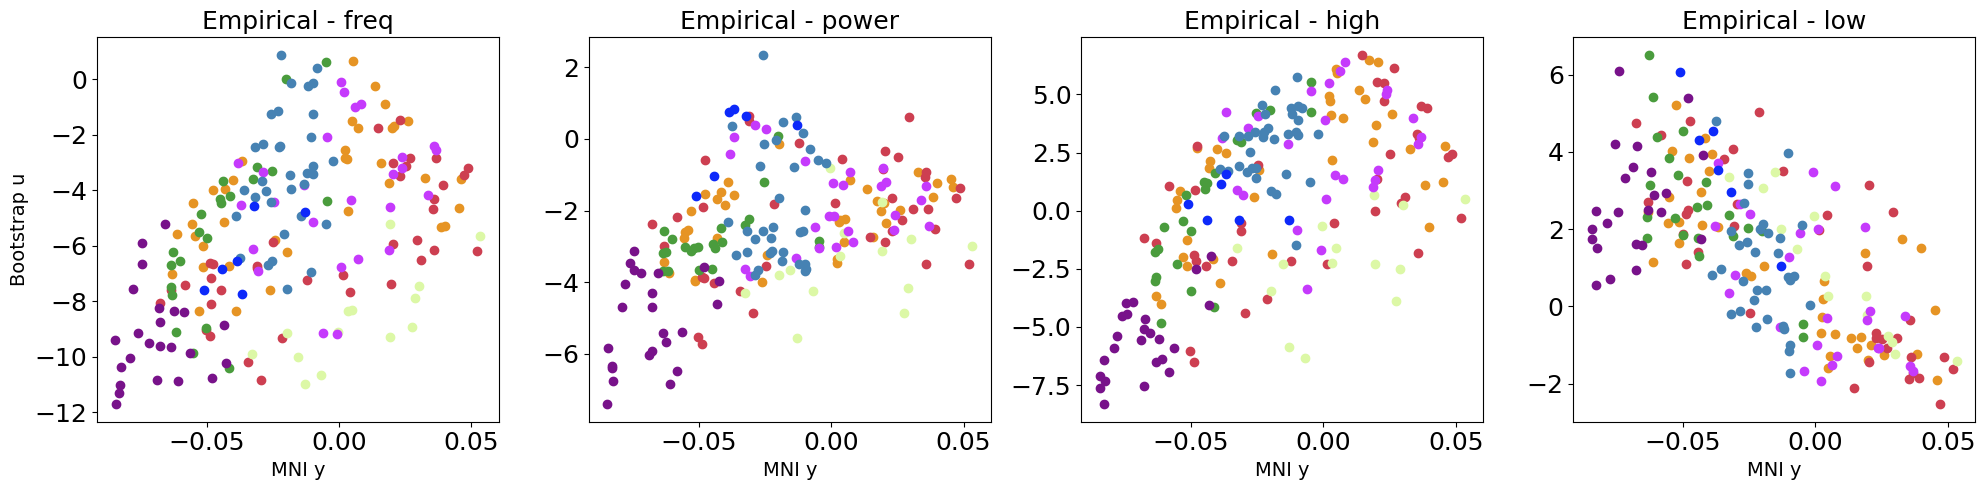

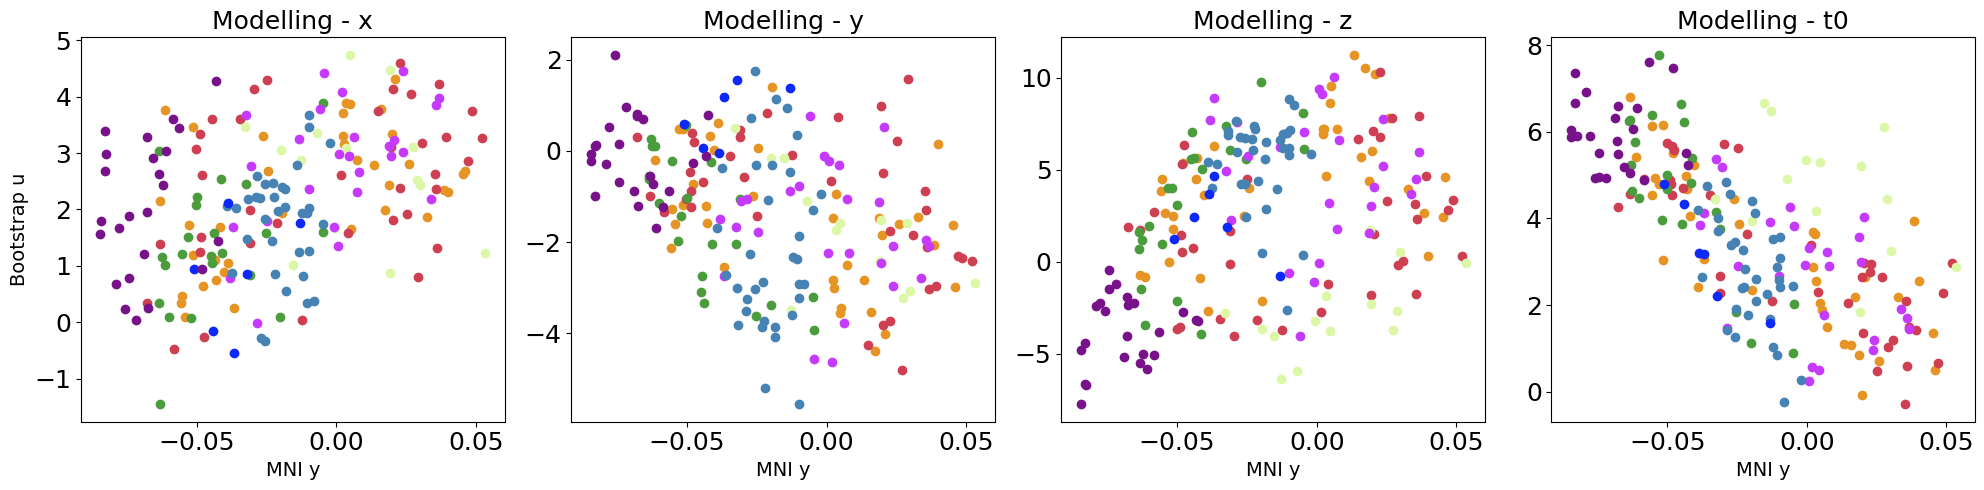

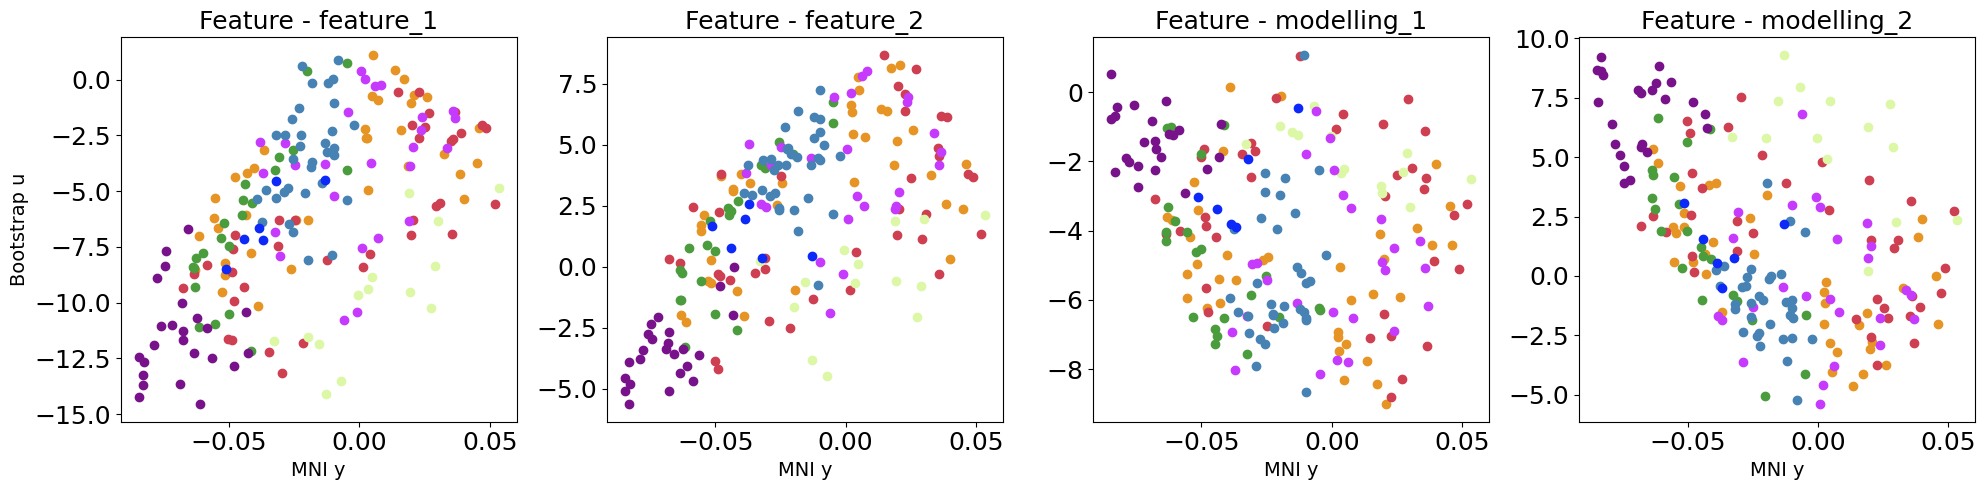

In [ ]:
subjects_dir = '/path_to_freesurfer/freesurfer_subjects'
subject = 'fsaverage_small'
os.environ['SUBJECTS_DIR'] = subjects_dir

# Load MATLAB ROI coordinate file
mat = loadmat('/data/ROI_coord.mat')
coordinates = mat['ROI_coord'][0]

# Load PLS results
pls_empirical = pd.read_csv('/data/bootstrap_empirical_final.csv')
pls_modelling = pd.read_csv('/data/bootstrap_xyzt0_final.csv')
pls_feature_modelling = pd.read_csv('/data/bootstrap_featuremodelling_final.csv')

# Plotting bootrsap ratios over MNI y axis


labels = mne.read_labels_from_annot(
    subject='fsaverage_small',
    parc="Schaefer2018_200Parcels_17Networks_order",
    subjects_dir=subjects_dir,
    verbose=False
)

label_names = [label.name for label in labels]

network_info = {
    'Cont': {'color': labels[1].color, 'x': [], 'y': []},
    'Default': {'color': labels[29].color, 'x': [], 'y': []},
    'DorsAttn': {'color': labels[43].color, 'x': [], 'y': []},
    'Limbic': {'color': labels[54].color, 'x': [], 'y': []},
    'SalVentAttn': {'color': labels[60].color, 'x': [], 'y': []},
    'SomMo': {'color': labels[71].color, 'x': [], 'y': []},
    'TempPar': {'color': labels[185].color, 'x': [], 'y': []},
    'Vis': {'color': labels[90].color, 'x': [], 'y': []},
}

def plot_pls_latent_maps(pls_df, latent_vars, coordinates, title_prefix=""):
    fig, axs = plt.subplots(1, len(latent_vars), figsize=(20, 5))

    for i, ax in enumerate(axs.flat):
        y_coord = pls_df[latent_vars[i]]

        # Clear previous values
        for net in network_info:
            network_info[net]['x'] = []
            network_info[net]['y'] = []

        # Collect points per network
        for idx, name in enumerate(label_names):
            for net in network_info:
                if net in name:
                    network_info[net]['x'].append(coordinates[idx])
                    network_info[net]['y'].append(y_coord[idx])
                    break

        # Plot
        for net, info in network_info.items():
            if info['x']:
                ax.scatter(info['x'], info['y'], color=info['color'], label=net)

        ax.set_xlabel('MNI y', fontsize=14)
        ax.set_title(f'{title_prefix}{latent_vars[i]}', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=18)
        if i == 0:
            ax.set_ylabel('Bootstrap u', fontsize=14)

    plt.tight_layout()
    plt.show()

# Plot for each PLS types
plot_pls_latent_maps(pls_empirical, ['freq', 'power', 'high', 'low'], coordinates, title_prefix='Empirical - ')
plot_pls_latent_maps(pls_modelling, ['x', 'y', 'z', 't0'], coordinates, title_prefix='Modelling - ')
plot_pls_latent_maps(pls_feature_modelling, ['feature_1', 'feature_2', 'modelling_1', 'modelling_2'], coordinates, title_prefix='Feature - ')



[fetch_surf_fsaverage] Dataset found in C:\Users\sorenza_bastiaens\nilearn_data\fsaverage

C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\nibabel\freesurfer\io.py:61: UserWarning: Unknown extension code.
  warnings.warn('Unknown extension code.')
C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\nibabel\freesurfer\io.py:187: UserWarning: No volume information contained in the file
  warnings.warn('No volume information contained in the file')
C:\Users\sorenza_bastiaens\AppData\Local\Temp\ipykernel_12064\1994674188.py:33: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(


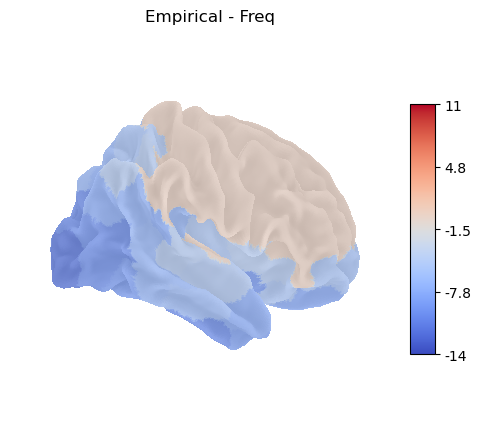

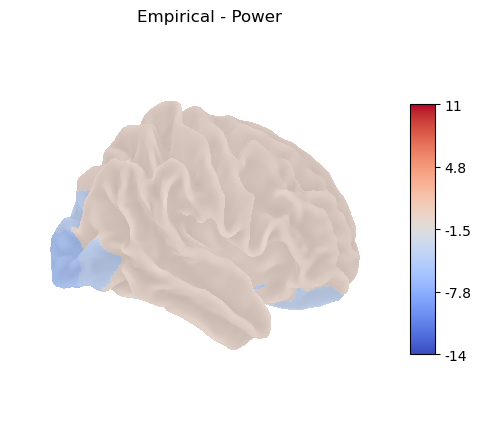

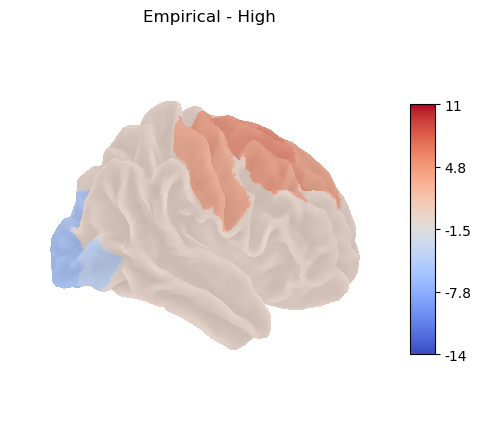

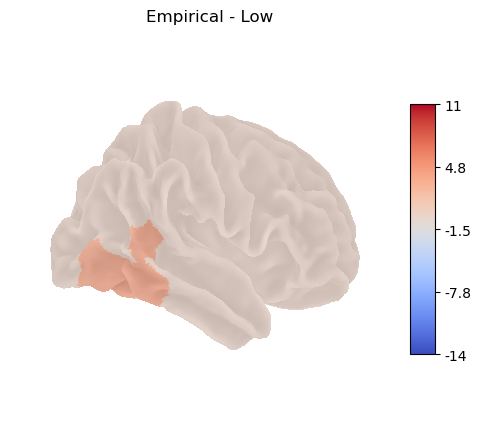

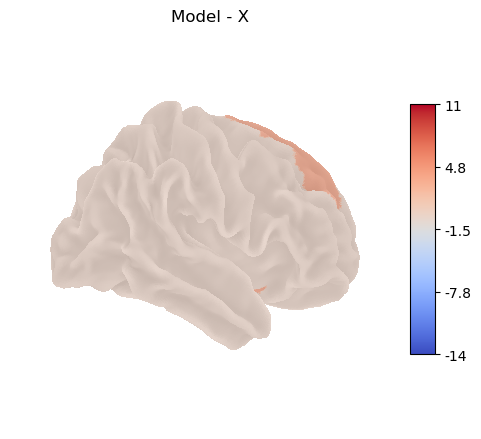

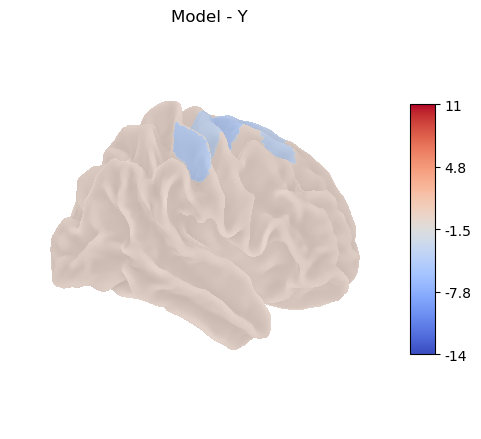

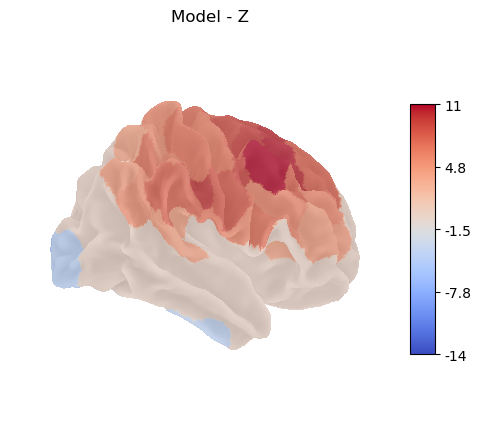

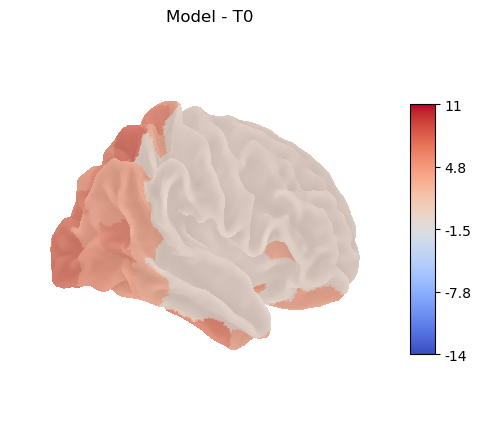

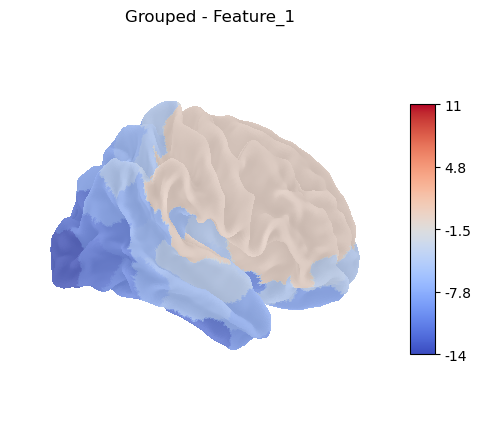

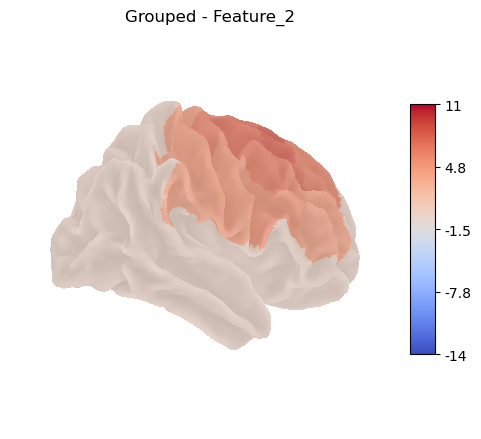

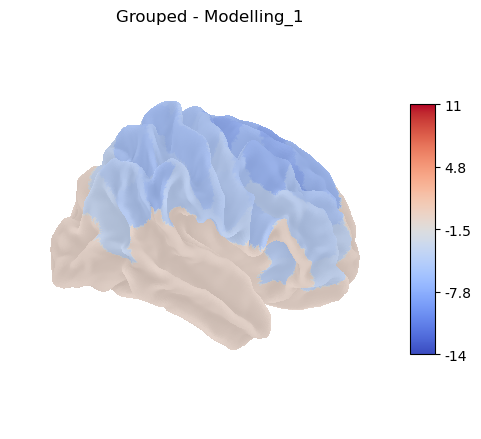

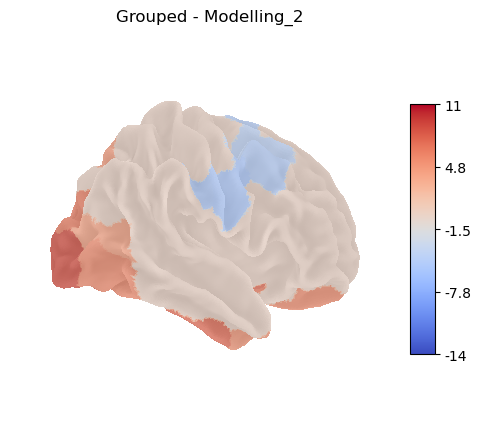

In [ ]:
# Plotting bootstrap ratios on brain of PLS

# Get white surface
fsaverage_directory = '/path_to_freesurfer/fsaverage_small/'
fsaverage = {
    'white_left': fsaverage_directory + 'surf/lh.white',
    'white_right': fsaverage_directory + 'surf/rh.white',
}

# Background cortical map
fs7 = fetch_surf_fsaverage(mesh='fsaverage')
lhc = surface.load_surf_data(fs7['curv_right'])

# Get vertices for each cortical ROIs
roi_to_vertices = [label.vertices for label in labels[:-2]]

# Define plotting function
def plot_pls_bsr_on_brain(pls_df, latent_vars, roi_to_vertices, fsaverage, bg_map, title_prefix=""):
    vertex_values = {}
    num_vertices = 163842

    for stat in latent_vars:
        roi_values_stat = pls_df[stat]
        vertex_values[stat] = np.full(num_vertices, np.nan)

        for roi_idx, vertices in enumerate(roi_to_vertices):
            vertex_values[stat][vertices] = roi_values_stat[roi_idx]

        # Threshold insignificant BSRs
        vertex_values[stat][(vertex_values[stat] >= -4) & (vertex_values[stat] <= 4)] = 0

        # Plot
        plotting.plot_surf_stat_map(
            fsaverage['white_right'], bg_map=bg_map, bg_on_data=True,
            stat_map=vertex_values[stat], hemi='right', view='lateral',
            vmin=-14, vmax=11, cmap='coolwarm', colorbar=True,
            title=f"{title_prefix}{stat.capitalize()}"
        )
        plt.show()


# Get vertices from ROIs 
roi_to_vertices = [label.vertices for label in labels[:-2]]

# Plot BSR for 4 PLS empirical
latent_vars_empirical = ['freq', 'power', 'high', 'low']
plot_pls_bsr_on_brain(pls_empirical, latent_vars_empirical, roi_to_vertices, fsaverage, lhc, title_prefix="Empirical - ")

# Plot BSR for 4 PLS modelling
latent_vars_model = ['x', 'y', 'z', 't0']
plot_pls_bsr_on_brain(pls_modelling, latent_vars_model, roi_to_vertices, fsaverage, lhc, title_prefix="Model - ")

# Plot BSR of latent variables 1 and 2 for grouped empirical and grouped model 
latent_vars_model = ['feature_1', 'feature_2', 'modelling_1', 'modelling_2']
plot_pls_bsr_on_brain(pls_feature_modelling, latent_vars_model, roi_to_vertices, fsaverage, lhc, title_prefix="Grouped - ")
